# Detecting food in Hyperspectral Images

George Miliarakis, Research Practice Report

Hungry Robots Lab  
Wageningen University & Research


### Libraries


In [40]:
# os.environ["KERAS_BACKEND"] = "tensorflow"
from datetime import datetime
from packaging import version
import os, re
# import numbers
# import math
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import scipy.io as sio
import skimage
import skimage.io as io
import pandas as pd
import matplotlib.pyplot as plt
import spectral

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from keras.ops.image import crop_images, pad_images, extract_patches
from tensorflow.image import crop_to_bounding_box
from keras.utils import to_categorical

import keras_cv
import keras_tuner as kt
from tensorflow import keras
from keras import ops, saving
from keras.layers import *
from keras_cv.layers import *
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
# from patchify import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier 
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, classification_report, brier_score_loss, ConfusionMatrixDisplay,  jaccard_score

In [41]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"})

In [42]:
features = 3

### Functions


In [ ]:
def preprocess(X, y, features, method = None):
    '''Wrapper to preprocess X and y for model training/testing'''
    y = skimage.color.rgb2gray(y)
    # y = skimage.exposure.adjust_gamma(y, 1)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    y = 1-y.T
    # y = 1-y
    # X = apply_PCA(X, features)
    X = X.reshape(-1,3)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    if method == None:
        # X, y = cubify(X,y)
        # X = X.ravel()
        y = y.ravel()
    # # else: 
    # #     X = extract_patches_2d(image = X, patch_size=(32,32), max_patches=512)
    # #     # X = np.reshape(X, (X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]))
    # #     y = extract_patches_2d(image = y, patch_size=(32,32), max_patches=512)
    # #     # y = np.reshape(y, (y.shape[0]*y.shape[1]*y.shape[2],-1))
    y = to_categorical(y, num_classes=2)
    return X, y

In [ ]:
## Zero padding
def pad0(X, margin=2):
    '''Pad X with margin zeros'''
    w, h, d = X.shape
    padX = np.zeros((w + 2 * margin, h + 2* margin, d))
    x_offset = margin
    y_offset = margin
    padX[x_offset:w + x_offset, y_offset:h + y_offset, :] = X
    return padX

## Image cubes creation
def cubify(X, y, size=32, drop0labels = False):
    '''Create cubes (patches) of X and y'''
    margin = int((size - 1) / 2)
    padX = pad0(X, margin=margin)
    w, h, d = X.shape
    # split patches
    Xcubes = np.zeros((w * h, size, size, d))
    ycubes = np.zeros((w * h))
    index = 0
    for r in range(margin, padX.shape[0] - margin):
        for c in range(margin, padX.shape[1] - margin):
            patch = padX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            Xcubes[index, :, :, :] = patch
            ycubes[index] = y[r-margin, c-margin]
            index += 1
    if drop0labels:
        Xcubes = Xcubes[ycubes>0,:,:,:]
        ycubes = ycubes[ycubes>0]
        ycubes -= 1
    return Xcubes, ycubes

In [64]:
def evaluate(y, yhat):
    if y.ndim == 2:
        y = np.argmax(y, axis=1)
    if yhat.ndim ==2:
        yhat = np.argmax(yhat, axis=1)
    report=classification_report(y,  yhat, digits=5, output_dict=True, zero_division = 0)
    metrics = pd.DataFrame(report)
    metrics.drop('support', axis=0, inplace=True)
    metrics.loc[len(metrics.index)] = metrics.iloc[0,2]
    metrics.drop(metrics.columns[0:4], axis=1, inplace=True)
    metrics.rename(index={3:'accuracy'}, inplace=True)
    metrics.loc[len(metrics.index)] = [roc_auc_score(y,yhat)]
    metrics.rename(index={4:'AUC'}, inplace=True)
    metrics.loc[len(metrics.index)] = [jaccard_score(y,  yhat)]
    metrics.rename(index={5:'Jaccard score (IoU)'}, inplace=True)
    metrics.loc[len(metrics.index)] = [brier_score_loss(y,yhat)]
    metrics.rename(index={6:'Brier score'}, inplace=True)
    metrics.sort_index(inplace=True)
    return metrics

### NN layer definition


In [43]:
@saving.register_keras_serializable(package="sase")
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(num_heads=1, key_dim=64, **kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

  def get_config(self):
    config = super(BaseAttention, self).get_config()
    config.update({})
    return config

In [44]:
@saving.register_keras_serializable(package="sase")
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

  def get_config(self):
    config = super(GlobalSelfAttention, self).get_config()
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [45]:
@saving.register_keras_serializable(package="sase")
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate=0.2, **kwargs):
    super().__init__(**kwargs)
    self.d_model = d_model
    self.dff = dff
    self.dropout_rate = dropout_rate
    self.seq = keras.models.Sequential([
      Dense(dff, activation='relu'),
      Dense(d_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x
  
  def get_config(self):
    config = super(FeedForward, self).get_config()
    config.update({
        "d_model": self.d_model,
        "dff": self.dff,
        "dropout_rate": self.dropout_rate
    })
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [46]:
def feed_forward(x, d_model, dff, dropout_rate=0.2, name_prefix=""):
    # First Dense layer with ReLU activation
    dense_1 = Dense(dff, activation='relu', name=f"{name_prefix}Dense_1")(x)
    
    # Second Dense layer (no activation)
    dense_2 = Dense(d_model, name=f"{name_prefix}Dense_2")(dense_1)
    
    # Dropout layer
    dropout = Dropout(dropout_rate, name=f"{name_prefix}Dropout")(dense_2)
    
    # Add layer (skip connection)
    add = Add(name=f"{name_prefix}Add")([x, dropout])
    
    # Layer Normalization
    norm = LayerNormalization(name=f"{name_prefix}LayerNorm")(add)
    
    return norm

# Example usage:
input_tensor = Input(shape=(1,64), name="Input")
output = feed_forward(input_tensor, d_model=64, dff=64, dropout_rate=0.2, name_prefix="FeedForward_")

model = Model(inputs=input_tensor, outputs=output, name="FeedForwardModel")
model.summary()

Model: "FeedForwardModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 1, 64)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dense_1 │ (None, 1, 64)     │      4,160 │ Input[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dense_2 │ (None, 1, 64)     │      4,160 │ FeedForward_Dens… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dropout │ (None, 1, 64)     │          0 │ FeedForward_Dens… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Add     │ (None, 1, 64)     │          0 │ Input[0][0],      │
│ (Add)               │                   │            │ FeedForward_Drop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_LayerN… │ (None, 1, 64)     │        128 │ FeedForward_Add[… │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,448 (33.00 KB)

 Trainable params: 8,448 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
@saving.register_keras_serializable(package="sase")
class SqueezeAndExcite1D(keras.Model):
    def __init__(self, filters, bottleneck_filters=None, squeeze_activation="relu", excite_activation="sigmoid", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

        if bottleneck_filters and bottleneck_filters >= filters:
            raise ValueError(
                "`bottleneck_filters` should be smaller than `filters`. Got "
                f"`filters={filters}`, and "
                f"`bottleneck_filters={bottleneck_filters}`."
            )

        if filters <= 0 or not isinstance(filters, int):
            raise ValueError(
                f"`filters` should be a positive integer. Got {filters}"
            )

        self.bottleneck_filters = bottleneck_filters or (filters // 4)
        self.squeeze_activation = squeeze_activation
        self.excite_activation = excite_activation
        self.global_average_pool = GlobalAveragePooling1D(keepdims=True)
        self.squeeze_conv = Conv1D(self.bottleneck_filters, 1, activation=self.squeeze_activation, name = 'squeeze')
        self.excite_conv = Conv1D(self.filters, 1, activation=self.excite_activation, name = 'excite')

    def call(self, inputs, training=None):
        x = self.global_average_pool(inputs)  # x: (batch_size, 1, filters)
        x = self.squeeze_conv(x)  # x: (batch_size, 1, bottleneck_filters)
        x = self.excite_conv(x)  # x: (batch_size, 1, filters)
        x = Multiply()([x, inputs])  # x: (batch_size, timesteps, filters)
        return x

    def get_config(self):
        config = {
            "filters": self.filters,
            "bottleneck_filters": self.bottleneck_filters,
            "squeeze_activation": self.squeeze_activation,
            "excite_activation": self.excite_activation,
            "squeeze_conv": self.squeeze_conv,
            "excite_conv":self.excite_conv
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if isinstance(config["squeeze_activation"], dict):
            config["squeeze_activation"] = keras.activations.deserialize(config["squeeze_activation"])
        if isinstance(config["excite_activation"], dict):
            config["excite_activation"] = keras.activations.deserialize(config["excite_activation"])
        if isinstance(config["squeeze_conv"], dict):
            config["squeeze_activation"] = keras.activations.deserialize(config["squeeze_conv"])
        if isinstance(config["excite_conv"], dict):
            config["excite_activation"] = keras.activations.deserialize(config["excite_conv"])
        return cls(**config)

### 1D SASE


In [48]:
def model1D():
    input_layer = Input(shape=(features,), name='input_layer')
    x = Reshape((1, features))(input_layer)
    c = Conv1D(filters=64, kernel_size=3, padding='same', activation='gelu')(x)
    s = SqueezeAndExcite1D(64)(c)
    g = GlobalSelfAttention()(s)
    f = FeedForward(64, 64)(g)
    s = Add()([c, f])
    s = LayerNormalization()(s)
    # FeedForward blocks
    g = GlobalSelfAttention()(s)
    f = FeedForward(64, 64)(g)
    x = Flatten()(f)
    # Dense layers
    x = Dense(units=64, activation='gelu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=64, activation='gelu')(x)
    x = Dropout(0.2)(x)
    
    output_layer = Dense(units=2, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.7758, weight_decay=0.00084),
        loss='binary_crossentropy',
        metrics=[keras.metrics.OneHotMeanIoU(num_classes=2, name='mIoU', sparse_y_pred=False), keras.metrics.F1Score(threshold=0.5), "acc", 'auc']
    )
    return model

In [49]:
model = model1D()

In [50]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 3)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 64)     │        640 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_and_excite… │ (None, 1, 64)     │      2,128 │ conv1d_2[0][0]    │
│ (SqueezeAndExcite1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_self_attent… │ (None, 1, 64)     │     16,768 │ squeeze_and_exci… │
│ (GlobalSelfAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_4      │ (None, 1, 64)     │      8,448 │ global_self_atte… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 1, 64)     │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ feed_forward_4[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_self_attent… │ (None, 1, 64)     │     16,768 │ layer_normalizat… │
│ (GlobalSelfAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_5      │ (None, 1, 64)     │      8,448 │ global_self_atte… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ feed_forward_5[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      4,160 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,778 (241.32 KB)

 Trainable params: 61,778 (241.32 KB)

 Non-trainable params: 0 (0.00 B)

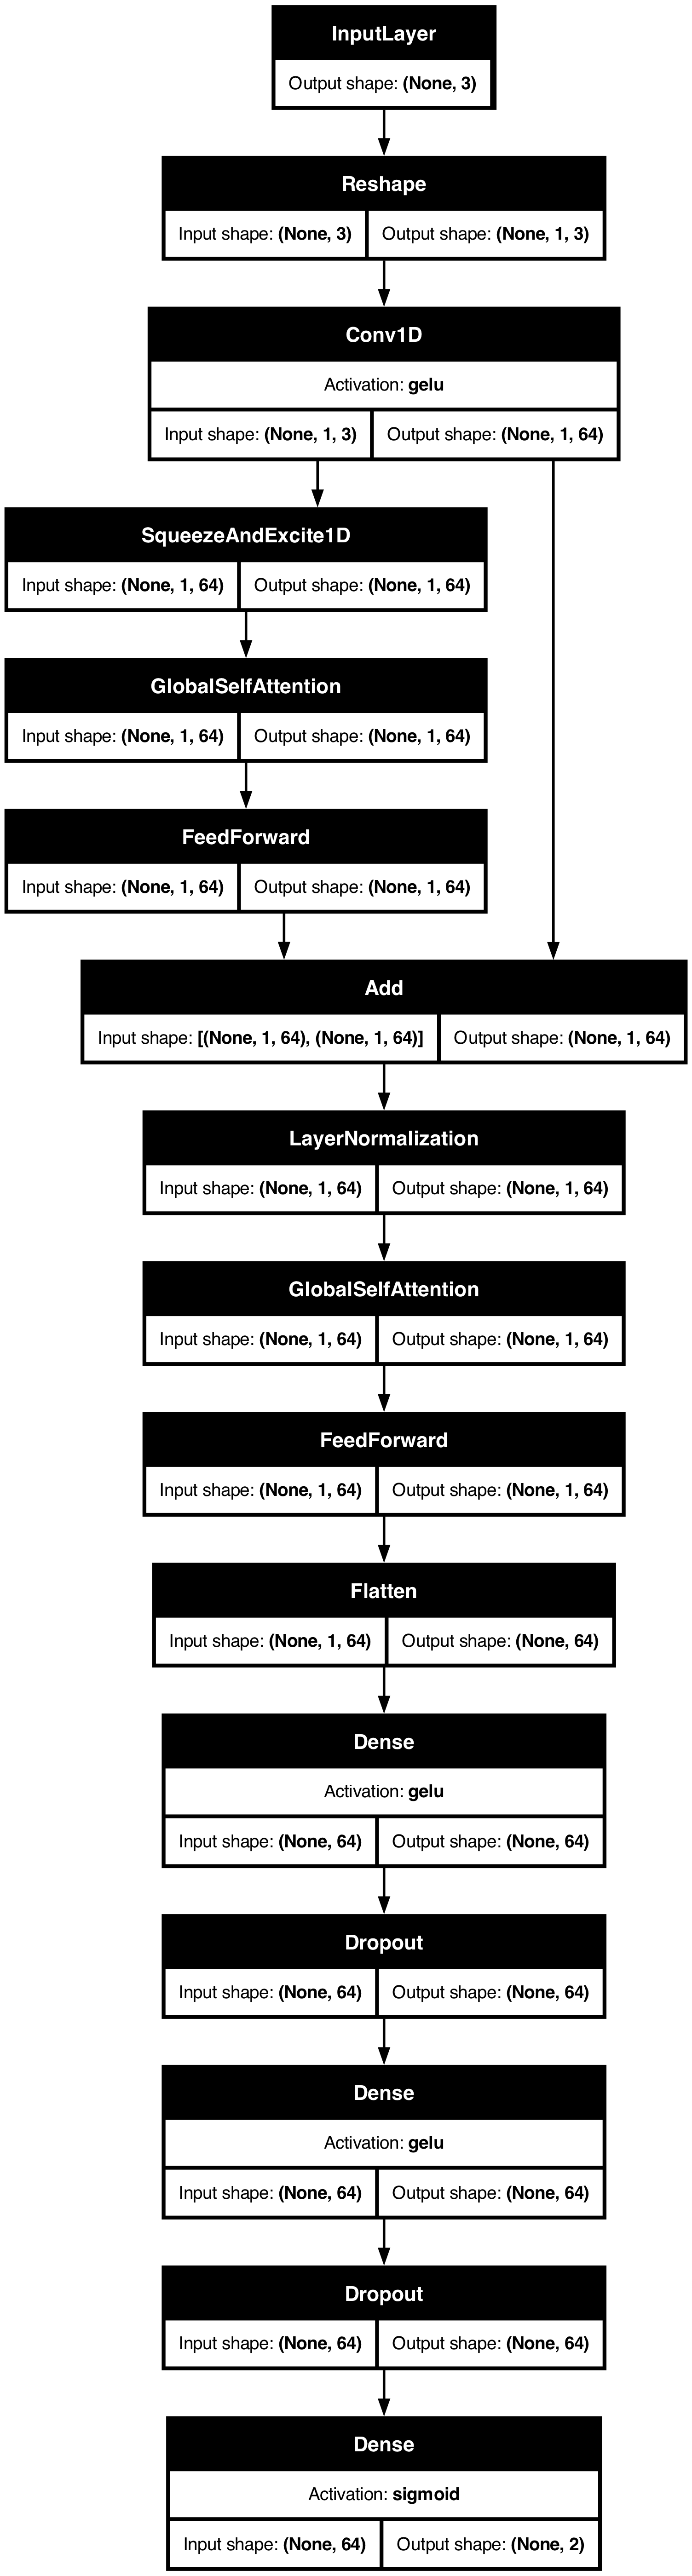

In [51]:
keras.utils.plot_model(model, 'Tex/figures/FF.png', True, False, show_layer_activations=True, expand_nested=True)

### Model training


In [52]:
rootdir = path = "mats/sandwiches/"
regex = re.compile(r'[A-Z][0-9][\w-]*(?=_corrected)')
pngs = []
mats = []
for root, dirs, files in os.walk(rootdir):
  for file in files:
    if regex.match(file) and file[-1]=='g':
      pngs.append(file)
    else:
      mats.append(file)
mats.sort()
pngs.sort()

In [53]:
mask3d = saving.load_model('mask.keras')

In [54]:
yhat_3d = []
yhat_sase = []

In [55]:
Xtrain = mats[:3]
ytrain = pngs[:3]

In [57]:
for mat, png in zip(Xtrain, ytrain):
    X = sio.loadmat(path+mat)['cube'] #load HSI
    y = skimage.io.imread(path+png) #load gt
    X, y = preprocess(X, y, 3)
    # checkpoint
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=0)
    model.fit(X,y, batch_size=256, epochs=2, callbacks=callback)
    

Epoch 1/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - acc: 0.9223 - auc: 0.9634 - f1_score: 0.8682 - loss: 0.3521 - mIoU: 0.8206
Epoch 2/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - acc: 0.9846 - auc: 0.9971 - f1_score: 0.9758 - loss: 0.1571 - mIoU: 0.9624
Epoch 1/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - acc: 0.9792 - auc: 0.9956 - f1_score: 0.9731 - loss: 0.1280 - mIoU: 0.9527
Epoch 2/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - acc: 0.9782 - auc: 0.9957 - f1_score: 0.9732 - loss: 0.1088 - mIoU: 0.9507
Epoch 1/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - acc: 0.9828 - auc: 0.9972 - f1_score: 0.9721 - loss: 0.0825 - mIoU: 0.9500
Epoch 2/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - acc: 0.9864 - auc: 0.9975 - f1_score: 0.9782 - loss: 0.0702 - mIoU: 0.9595


## Model Testing


In [ ]:
results = [] #save results
path='mats/sandwiches/' #set root directory
for mat, png in zip(mats[3:], pngs[3:]):
    X = sio.loadmat(path+mat)['cube'] #load HSI
    y = skimage.io.imread(path+png) #load gt
    im1 = [X.T[0], r"spectral feature $\displaystyle \frac{R_{1300:1327 \mathrm{nm}}}{R_{1485:1512 \mathrm{nm}}}$"+"\n"]
    im2 = [X.T[1], r"spectral feature $\displaystyle \frac{R_{1300:1327 \mathrm{nm}}-R_{1485\:1512 \mathrm{nm}}}{R_{1300:1327 \mathrm{nm}}+R_{1485:1512 \mathrm{nm}}}$"+"\n"]
    
    # preprocess ground truth image
    y = skimage.color.rgb2gray(y)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    y = 1-y
    im3 = [1-y, "PerClass Mira"]
    
    # Perform KMeans clustering
    X = sio.loadmat(path+mat)['cube']
    m, c = spectral.kmeans(X, 2, 20)
    im4 = [1-m.T, "KMeans clusters"]

    # X = apply_PCA(X, features)
    # X = X.reshape(539, 554, 3)
    X, y = cubify(X, y.T, 25)
    y = to_categorical(y, 2)
    yhat = mask3d.predict(X, batch_size=256)
    yhat_3d.append(yhat)
    yhat = yhat[:, 1].reshape(257, 407).T
    skimage.io.imsave(f'masks/sandwiches/3d/{mat[:-4]}.png', yhat.astype(np.uint8))
    # Placeholder for 3D CNN result (you need to replace this with actual result)
    im5 = [1-yhat, "3D CNN"]
    
    # Preprocess for SASE model and make prediction
    X = sio.loadmat(path+mat)['cube'] #load HSI
    y = skimage.io.imread(path+png) #load gt
    X, y = preprocess(X, y, 3)
    yhat = model.predict(X, batch_size=256) #detect food-bg
    yhat_sase.append(yhat)
    yhat = np.argmax(yhat, axis=1).reshape(257, 407).T
    skimage.io.imsave(f'masks/sandwiches/sase/{mat[:-4]}.png', yhat.astype(np.uint8))
    # print('\nDisplaying performance metrics')
    # metrics = evaluate(y, yhat) #get the classification performance metrics
    im6 = [yhat, "1D SASE"]
    
    # List to hold all images and titles
    images = [im1, im2, im3, im4, im5, im6]

In [60]:
ys = io.imread(path+pngs[0])
ys = skimage.color.rgb2gray(ys)
ys[np.where(ys>0.5)] = 1
ys[np.where(ys<0.5)] = 0
ys = 1-ys
ys = np.array([])
for png in pngs[1:]:
    y = io.imread(path+png)
    y = skimage.color.rgb2gray(y)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    y = 1-y
    ys = np.concatenate((ys, y.ravel()))


In [61]:
scaler = StandardScaler()

In [62]:
path='mats/sandwiches/' #set root directory
ys = yhat_3d = yhat_sase = np.array([])

for mat, png in zip(mats[3:], pngs[3:]):
    X = sio.loadmat(path+mat)['cube'] #load HSI
    s = X.shape
    y = skimage.io.imread(path+png) #load gt
    # preprocess ground truth image
    y = skimage.color.rgb2gray(y)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    y = 1-y
    ys = np.concatenate((ys, y.ravel()))
    
    X = X.reshape(-1,3)
    X = scaler.fit_transform(X)
    X = X.reshape(s[0],s[1],s[2])
    X, y = cubify(X, y.T, 25)
    y = to_categorical(y, 2)
    yhat = mask3d.predict(X, batch_size=256)
    yhat = np.argmax(yhat, axis=1).reshape(257, 407).T
    yhat_3d = np.concatenate((yhat_3d,yhat.ravel()))
    skimage.io.imsave(f'masks/sandwiches/3d/{mat[:-4]}.png', yhat.astype(np.uint8))
    
    # Preprocess for SASE model and make prediction
    X = sio.loadmat(path+mat)['cube'] #load HSI
    y = skimage.io.imread(path+png) #load gt
    X, y = preprocess(X, y, 3)
    yhat = model.predict(X, batch_size=256) #detect food-bg
    yhat = np.argmax(yhat, axis=1).reshape(257, 407).T
    yhat_sase = np.concatenate((yhat_sase,yhat.ravel()))
    skimage.io.imsave(f'masks/sandwiches/sase/{mat[:-4]}.png', yhat.astype(np.uint8))

409/409 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5

In [65]:
res  = pd.concat([evaluate(ys, yhat_3d), evaluate(ys, yhat_sase)], axis=1)
res.columns = ['3D CNN', '1D SASE']
res

,3D CNN,1D SASE
AUC,0.79,0.97
Brier score,0.31,0.02
Jaccard score (IoU),0.57,0.98
accuracy,0.69,0.98
f1-score,0.70,0.98
precision,0.86,0.98
recall,0.69,0.98
